Installing torchinfo module to visualize the final model

In [1]:
!pip install torchinfo

In [2]:
# Importing necessary libraries

import os
import random
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

import torchvision
from PIL import Image
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

# Introduction: Vision Transformers (ViTs)

Transformers have revolutionized Natural Language Processing (NLP), but their impact is not limited to text. In recent years, Vision Transformers (ViTs) have emerged as a powerful alternative to traditional Convolutional Neural Networks (CNNs) for image classification tasks. Unlike CNNs, which process images using hierarchical feature maps, ViTs treat an image as a sequence of patches and apply self-attention to model long-range dependencies across the entire image.

In this notebook, I will implement a Vision Transformer (ViT) from scratch using PyTorch, train it on the Tiny ImageNet dataset, and analyze its performance. This project aims to deepen the understanding of self-attention mechanisms in computer vision and explore the challenges of training ViTs without large-scale pretraining.

## 1. Preparing data for training

#### 1.1. About the data set

Training Vision Transformers (ViTs) from scratch requires large-scale datasets like ImageNet-21k or JFT-300M. However, due to computational limitations, we use Tiny ImageNet, a lightweight benchmark dataset that retains the complexity of ImageNet while being manageable on standard hardware.

About Tiny ImageNet
200 object categories (compared to 1000 in ImageNet)
500 training images per class (64×64 resolution)
50 validation images per class
100,000 total images, making it ideal for rapid prototyping and experimentation with deep learning models.
In the next steps, we will download, extract, and preprocess the Tiny ImageNet dataset before training our Vision Transformer model.

In [ ]:
# Extracting dataset stored in archive.zip

import zipfile

archive_path = "./archive.zip"
extract_path = "./"

if not os.path.exists("tiny-imagenet-200"):
    with zipfile.ZipFile(archive_path, "r") as zf:
        zf.extractall(extract_path)
    
    print("Data extraction completed.")
else:
    print(f"Data already exists")

Data extraction completed.


In [40]:
# Setting up paths
DATA_DIR = "tiny-imagenet-200/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train")
TEST_IMAGES_DIR = os.path.join(DATA_DIR, "test", "images")
VAL_IMAGES_DIR = os.path.join(DATA_DIR, "val", "images")

# Seeing contents of the dataset
print("Contents of DATA_DIR", os.listdir(DATA_DIR))
print("First 5 contents of TRAIN_IMAGES_DIR", os.listdir(TRAIN_IMAGES_DIR)[:5])
print("First 5 contents of VAL_IMAGES_DIR", os.listdir(VAL_IMAGES_DIR)[:5])
print("First 5 contents of TEST_IMAGES_DIR", os.listdir(TEST_IMAGES_DIR)[:5])

Contents of DATA_DIR ['train', 'val', 'words.txt', 'wnids.txt', '.ipynb_checkpoints', 'test']
First 5 contents of TRAIN_IMAGES_DIR ['n02814533', 'n02113799', 'n02883205', 'n04597913', 'n03733131']
First 5 contents of VAL_IMAGES_DIR ['val_3701.JPEG', 'val_7022.JPEG', 'val_558.JPEG', 'val_1403.JPEG', 'val_7263.JPEG']
First 5 contents of TEST_IMAGES_DIR ['test_2094.JPEG', 'test_5720.JPEG', 'test_3805.JPEG', 'test_3094.JPEG', 'test_7928.JPEG']


#### 1.2. Creating training data set and data loader

Before we can load the training data we have to set up transforms. Becaus we only have 500 test images per class in our training data we have to use augmentation to improve the model performance.

We will use the following transforms:
1. Resize the images to 64 x 64
2. Do a random horizontal flip
3. Use `torchvision.transforms.RandAugment` to randomly augment the training data

In [41]:
%%time
# Setting up training data set train dataloader

train_transform = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=6),
    T.ToTensor()
    # Using Imagenet global mean and std to normalize tiny-imagenet
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=TRAIN_IMAGES_DIR, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)

CPU times: user 181 ms, sys: 62.4 ms, total: 244 ms
Wall time: 1.42 s


In [42]:
# Checking that dataloader is working as expected
samples, labels = next(iter(train_dataloader))
print("Train dataloader length", len(train_dataloader))
print(f"Samples shape: {samples.shape} | Labels shape: {labels.shape}")

Train dataloader length 1563
Samples shape: torch.Size([64, 3, 64, 64]) | Labels shape: torch.Size([64])


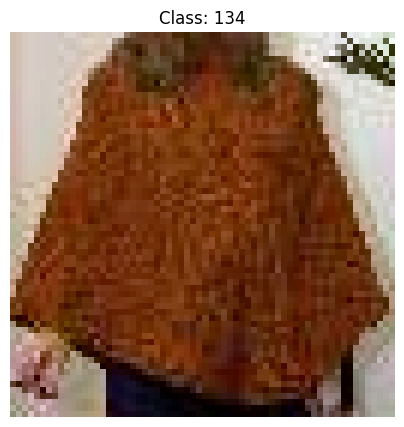

In [37]:
# Plotting a random image from samples
idx = random.randint(0, 63)
img, lbl = samples[idx], labels[idx]

plt.figure(figsize=(5, 5))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {lbl.item()}")
plt.axis(False)
plt.show()

#### 1.3. Creating validation dataset and dataloader

For the validation set, the images are not separated into different folder for each class. So we can not use `torchvision.dataset.ImageFolder` here. We will create a custom dataset class to create dataset and dataloader.

This custom class will do the following:
- Save paths to each validation image.
- Create a mapping between image name and corresponding class name from annotation.
- Return `PIL.Image` and its class index in the `__getitem__` method.

To create this custom class we will need:
1. Path to validation images
2. Path to annotations file
3. Class to index mapping from train dataset
4. Optional transforms to transform images before returning them

In [43]:
# Creating custom dataset for validation images


class TinyImagenetValidationDataset(Dataset):
    def __init__(self, img_dir, annotations_file, class_to_idx, transform=None):
        """
        Args:
            img_dir (str): Path to the validation images directory.
            annotations_file (str): Path to the val_annotations.txt file.
            class_to_idx (dict): Mapping from class names to class indices.
            transform (torchvision transforms): Optional transforms to apply to images.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.img_labels = {}  # Maps image to class index

        # Read annotations file and store image-label mappings
        with open(annotations_file, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                img_name = parts[0]
                class_name = parts[1]
                self.img_labels[img_name] = self.class_to_idx[class_name]

        # Store image filenames for indexing
        self.img_filenames = list(self.img_labels.keys())

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_name = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        label = self.img_labels[img_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [44]:
%%time
# Setting up validation dataset and dataloader

test_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

class_to_idx = train_dataset.class_to_idx
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
val_annotations_file = os.path.join(DATA_DIR, "val", "val_annotations.txt")
val_dataset = TinyImagenetValidationDataset(VAL_IMAGES_DIR, val_annotations_file, class_to_idx, test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

CPU times: user 3.29 ms, sys: 2.97 ms, total: 6.26 ms
Wall time: 9.74 ms


In [40]:
# Testing the validation dataloader
samples, labels = next(iter(val_dataloader))
print("Train dataloader length", len(val_dataloader))
print(f"Samples shape: {samples.shape} | Labels shape: {labels.shape}")

Train dataloader length 157
Samples shape: torch.Size([64, 3, 64, 64]) | Labels shape: torch.Size([64])


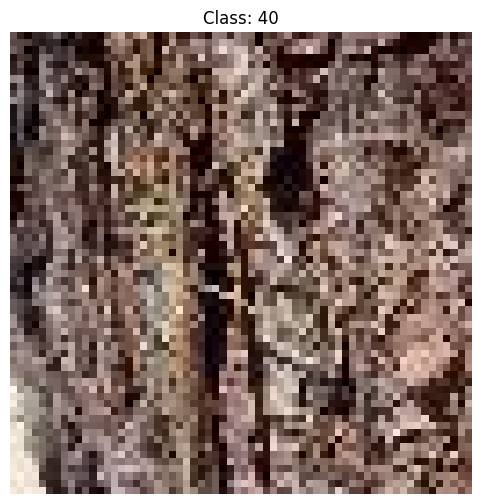

In [41]:
# Plotting a random denormalized image from validation set

idx = random.randint(0, 63)
img, lbl = samples[idx], labels[idx]

plt.figure(figsize=(10, 6))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {lbl.item()}")
plt.axis(False)
plt.show()

## 2. Re-creating the Vision Transformer Model

There are _ core parts of a Vision Transformer
1. **Patch Embeddings** - Converts the input image into fixed size patches, flattens them and projects them into an embedding space. Also, adds a learnable class token and position embeddings to retain spatial data.
2. **Multi Headed Self Attention** - Learns relationships between different patches of the image allowing the model to learn wider dependencies in the image.
3. **Multi Layer Perceptron** - This is a feed forward layer that expands feature dimensions and adds non-linearity to the network using GELU activation.
4. **Transformer Encoder Block** - Uses Multi-Headed Self Attention (MHSA) and Multi Layer Perceptron (MLP) with Residual connections to create a holistic understanding of the image.

I will use the default sizes from the ViT paper to create this model. That means the image dimensions will be 224 x 224, patch size is 16 and embeddings dimension is 768.

#### 2.1 Creating Patch Embeddings layer

The `PatchEmbeddings` layer of the Vision Transformer converts the input image into fixed size blocks. These blocks are then flattened into a single dimension. It also creates a learnable `ClassToken` and `PositionEmbeddings`, the class token is prepended to the flattened feature maps and then the position embeddings are added.

We will follow the below steps to recreate this layer:
1. Convert the image to patches using `torch.nn.Conv2d`.
2. Flatten the image patches into a single dimension tensor using `torch.nn.Flatten`.
3. Create a learnable Class Token using `nn.Parameter`.
4. Create a learnable Position Embedding using `nn.Parameter`
5. Prepend the Class Token to the flattened feature maps.
6. Add Position Embeddings to the flattened feature maps.

In [4]:
class PatchEmbeddings(nn.Module):
    """Class to convert a 2D image into 1D learnable embedding tensor"""
    def __init__(self,
                 img_size: int = 64,
                 in_channels: int = 3,
                 patch_size: int = 4,
                 embedding_dim: int = 256):
        super(PatchEmbeddings, self).__init__()
        
        assert img_size % patch_size == 0, f"Image size should be a multiple of patch size. Image size {img_size} and patch size {patch_size}"
        
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Conv2d patching layer
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # Creating class token
        self.class_token = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        
        # Creating position embeddinggs
        self.position_embeddings = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

        # Flatten layer
        # Flatten the height and width dimension into a single dimension
        # while preserving color channels and batch dimensions.
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, X: torch.Tensor):
        # Checking if inputs are correct
        batch_size = X.shape[0]
        
        # Perform the forward pass
        x_patched = self.patcher(X)
        x_flattened = self.flatten(x_patched)

        # Making sure that the output dimensions are in the right order
        x_flatten = x_flattened.permute(0, 2, 1)
        
        # Getting the class token
        class_token = self.class_token.expand(batch_size, -1, -1)
        
        # Prepending class token to patch embedding
        X = torch.cat((class_token, x_flatten), dim=1)
        
        # Adding position embeddings
        X = X + self.position_embeddings
        return X

In [43]:
# Testing the PatchEmbeddings class

patchefier = PatchEmbeddings()
image = torch.randn(3, 64, 64).unsqueeze(0)    # Adding batch dimension
print(f"Input dimensions: {image.shape}")
patch_pos_embedding_out = patchefier(image)
print(f"Patch Embedding dimensions: {patch_pos_embedding_out.shape}")

Input dimensions: torch.Size([1, 3, 64, 64])
Patch Embedding dimensions: torch.Size([1, 257, 256])


#### 2.2 Creating Multi-Headded Self-Attention block

To create the MHSA block we will use some prebuilt layers available in PyTorch.
- Multi-Headed Self-Attention (MHSA) - `torch.nn.MultiheadAttention`
- Layer Norm (LN) - `torch.nn.LayerNorm`
- Residual connection - add the input from previous layer to its output

**Layer Norm:**

A LayerNorm standardizes the input tensor to have similar mean and standard deviation. This helps neural networks to optimize data and improve efficiency.

**Multi-Headed Self-Attention:**

The original Transformer architecture relies on the power of self-attention or multi-head attention (self-attention applied multiple times).

Originally designed for text input, the self-attention mechanism takes a sequence of words and then calculates which word should pay more **attention** to another word.

Since our input is a sequence of image patches rather than words, self-attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of the image.

The implementation of multi-head attention takes three inputs query, key and value. In our case, this input will be three versions of the output of the Norm layer, one for query, key and value.




To do so we will:
1. Create a class called `MultiHeadSelfAttentionBlock`.
2. Initialize the class with hyper-parameters from ViT paper for the base ViT model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm` with the `normalized_shape` parameter the same as our embedding embedding dimension.
4. Create a multi-head self attention (MHSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create the `forward` method for our class passing the inputs through the LN and MHSA layers.

In [5]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a Multi-Headded Self-Attention block for Vision Transformer"""
    def __init__(self, embedding_dim: int = 256, num_heads: int = 8, attn_dropout: float = 0):
        super(MultiHeadSelfAttentionBlock, self).__init__()

        # Creating the normalization layer
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Creating the MHSA layer
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                          num_heads=num_heads,
                                          dropout=attn_dropout,
                                          batch_first=True)

    def forward(self, X: torch.Tensor):
        X = self.norm(X)
        X, _ = self.attn(query=X, key=X, value=X, need_weights=False)
        return X

In [45]:
# Testing MHSA block
multi_head_sa_block = MultiHeadSelfAttentionBlock(embedding_dim=256, num_heads=8)
mhsa_out = multi_head_sa_block(patch_pos_embedding_out)
print(f"Tensor shape before MHSA block: {patch_pos_embedding_out.shape}")
print(f"Tensor shape after MHSA block: {mhsa_out.shape}")

Tensor shape before MHSA block: torch.Size([1, 257, 256])
Tensor shape after MHSA block: torch.Size([1, 257, 256])


#### 2.3 Creating the Multilayer Perceptron block

Let us now create the last part of the Vision Transformer, the Transformer Encoder Block. This block uses a Multi Layer Perceptron (MLP) layer and the Multi-Headed Self-Attention (MHSA) layers to produce the final output. It achieves this by passing the outputs of MHSA layer through an MLP layer which is just a dense layer that outputs the image class.

We will implement the following to complete our Transformer Encoder Block:
1. Replicate the `MLPLayer` from ViT paper with parameters for the base ViT model.
2. Create a `TransformerEncoderBlock` class to combine `MultiHeadSelfAttentionBlock` and `MLPLayer`.

In [6]:
class MLPLayer(nn.Module):
    """Creates a normalized multi layer perceptron block"""
    def __init__(self, embedding_dim:int = 256, mlp_size:int = 1024, dropout:float = 0.1):
        super(MLPLayer, self).__init__()

        # Lormalization layer
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multi layer perceptron layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, X: torch.Tensor):
        X = self.norm(X)
        X = self.mlp(X)
        return X

In [47]:
# Testing the MLP block
mlp_block = MLPLayer(embedding_dim=256, mlp_size=1024, dropout=0.1)
mlp_out = mlp_block(mhsa_out)
print(f"Tensor shape before MLP block: {mhsa_out.shape}")
print(f"Tensor shape after MLP block: {mlp_out.shape}")

Tensor shape before MLP block: torch.Size([1, 257, 256])
Tensor shape after MLP block: torch.Size([1, 257, 256])


In [7]:
class TransformerEncoderBlock(nn.Module):
    """Creates a ViT transformer encoder block"""
    def __init__(self,
                 embedding_dim:int=256,
                 num_heads:int=8,
                 mlp_size:int=1024,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super(TransformerEncoderBlock, self).__init__()

        # Create the MSA block
        self.msa = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout)

        # Create teh MLP block
        self.mlp = MLPLayer(embedding_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

    def forward(self, X: torch.Tensor):
        # Create residual connection for MSA block
        X = self.msa(X) + X

        # Create residual connection for MLP block
        X = self.mlp(X) + X
        return X

In [49]:
# Testing the Transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()
transormer_encoder_out = transformer_encoder_block(patch_pos_embedding_out)
print(f"Tensor shape before Transformer Encoder block: {patch_pos_embedding_out.shape}")
print(f"Tensor shape after Transformer Encoder block: {transormer_encoder_out.shape}")

Tensor shape before Transformer Encoder block: torch.Size([1, 257, 256])
Tensor shape after Transformer Encoder block: torch.Size([1, 257, 256])


## Putting it all together to create ViT

Now that we have replicated all parts of the ViT model separately, its time to put them together and create the full ViT model.

To do this we will:
1. Create a class `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyper-parameters from the ViT paper for the base model.
3. Setup the embedding dropout layer.
4. Create the patch embedding layer using the `PatchEmbedding` class.
5. Create a series of Transformer Encoder Blocks by passing a list of `TransformerEncoderBlocks` to `torch.nn.Sequential()`.
6. Create a classifier head using `nn.LayerNorm()` and `nn.Linear()` and passing them through `nn.Sequential()`
7. Create a `forward()` method that accepts an input.
8. Get patch and position embeddings from the `PatchEmbeddings` layer.
9. Pass the patch and position embedding through the dropout layer created in step 3.
10. Pass the patch and position embedding from step 9 through the stack of Transformer Encoder layers.
11. Pass index 0 of the output of the stack of Transformer Encoder layers from previous step through the classifier head created.

And we are done with the full Vision Transformer model.

In [8]:
class ViT(nn.Module):
    """Creates a vision transformer model"""
    def __init__(self,
                 img_size: int = 64,                # Training resolution from ViT paper
                 in_channels: int = 3,              # Number of color channels in the input image
                 patch_size: int = 4,               # Patch size
                 num_transformer_layers: int = 12,  # Layers from ViT paper for ViT-Base
                 embedding_dim: int = 256,          # Hidden size D from the paper for ViT-Base
                 mlp_size: int = 1024,              # MLP size from the paper for ViT-Base
                 num_heads: int = 8,                # Heads from the paper for ViT-Base
                 attn_dropout: float = 0,           # Dropout for attention projection
                 mlp_dropout: float = 0.1,          # Dropout for dense/MLP layers
                 embedding_dropout: float = 0.1,    # Dropout for patch and position embeddings
                 num_classes: int = 200):           # Default for ImageNet, can be customized
        super(ViT, self).__init__()
        
        # Check if image size is completely divisible by patch size
        assert img_size % patch_size == 0, f"Image size should be a multiple of patch size. Image size {img_size} and patch size {patch_size}"

        # Creating a dropout for patch embeddings
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Creating a patch embeddings layer
        self.patch_embed_layer = PatchEmbeddings(img_size=img_size,
                                                 in_channels=in_channels,
                                                 patch_size=patch_size,
                                                 embedding_dim=embedding_dim)

        # Creating a transformer encoder blocks
        self.tfm_enc_blocks = nn.Sequential(
            *[
                TransformerEncoderBlock(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        mlp_size=mlp_size,
                                        mlp_dropout=mlp_dropout,
                                        attn_dropout=attn_dropout)
                for _ in range(num_transformer_layers)
            ]
        )

        # Creating the classifier head
        self.fcs = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, X: torch.Tensor):
        # Creating patch embeddings
        X = self.patch_embed_layer(X)

        # Passing it through embedding dropout
        X = self.embedding_dropout(X)

        # Passing it through transformer encoder blocks
        X = self.tfm_enc_blocks(X)

        # Passing the 0 indexed logits through classifier
        X = self.fcs(X[:, 0])
        return X

In [51]:
# Testing out the ViT model on one random batch

model = ViT(num_classes=len(class_to_idx))
random_image_tensor = torch.randn(64, 3, 64, 64)
vit_out = model(random_image_tensor)
print(f"Shape of the input of ViT model: {random_image_tensor.shape}")
print(f"Shape of the final output of ViT model: {vit_out.shape}")

Shape of the input of ViT model: torch.Size([64, 3, 64, 64])
Shape of the final output of ViT model: torch.Size([64, 200])


In [52]:
# Checking size of our model using torchinfo

summary(model=model,
        input_size=(64, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [64, 3, 64, 64]      [64, 200]            --                   True
├─PatchEmbeddings (patch_embed_layer)              [64, 3, 64, 64]      [64, 257, 256]       66,048               True
│    └─Conv2d (patcher)                            [64, 3, 64, 64]      [64, 256, 16, 16]    12,544               True
│    └─Flatten (flatten)                           [64, 256, 16, 16]    [64, 256, 256]       --                   --
├─Dropout (embedding_dropout)                      [64, 257, 256]       [64, 257, 256]       --                   --
├─Sequential (tfm_enc_blocks)                      [64, 257, 256]       [64, 257, 256]       --                   True
│    └─TransformerEncoderBlock (0)                 [64, 257, 256]       [64, 257, 256]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa)  

Now that's a massive model with over 85 million trainable parameters. Training the model will be a massive task. Due to the limited hardware, we will reduce the number of transformer layers if it takes too long to train the model.

Finally we have replicated all the core layers of the Vision Transformer model and passed a random image through the model. The model outputs a tensor of length 200 for each image in the batch. Each element of the tensor correspond to the probability of the image belonging to that class. We can extract the class index from this tensor using `torch.argmax()` function and then get the name of the class using `index_to_class` dictionary.

## 3. Training the model

Now that we have succesfully recreated the ViT model, we are all set to train it on our `tiny-imagenet-200` dataset. We have already created the `train_dataloader` and the `test_dataloader`. Now we just need to set-up the training and testing loops. We will modularize this part as well and create separate, reusable functions for training loop and testing loop. We will also leverage GPUs to accelerate training of the model. We will also use `torch.amp.GradScaler()` to speed up training process.

In [10]:
# Setting up device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device.type}")

Training on device: cuda


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.cuda.amp.GradScaler,
               device: torch.device = device):
    # Putting the model in training mode
    model.train()

    # Creating metrics that will be tracked throughout the step
    train_loss, train_acc, total_samples = 0, 0, 0

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Training")):
        # Sending X and y to the target device
        X, y = X.to(device), y.to(device)

        # Making prediction and calculating loss
        with torch.amp.autocast("cuda", enabled=device.type == "cuda"):
            preds = model(X)
            loss = loss_fn(preds, y)
        
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward and optimizer step
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Calculating accuracy
        pred_classes = torch.argmax(preds, dim=1)
        train_acc += (pred_classes == y).sum().item()
        total_samples += y.size(0)

    # Adjusting training loss and accuracy per batch
    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    # Putting the model in evaluation mode
    model.eval()

    # Creating metrics that will be tracked throughout the step
    test_loss, test_acc, total_samples = 0, 0, 0

    with torch.inference_mode():
        with torch.amp.autocast("cuda", enabled=device.type == "cuda"):
            for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Evaluating")):
                # Sending X and y to target device
                X, y = X.to(device), y.to(device)

                # Making predictions
                test_pred_logits = model(X)

                # Calculating loss
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()

                # Calculating test accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += (test_pred_labels == y).sum().item()
                total_samples += y.size(0)

            # Adjusting training loss and accuracy per batch
            test_loss /= total_samples
            test_acc /= total_samples
            return test_loss, test_acc

In [56]:
def train_model(model: torch.nn.Module,
                model_save_path: str,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                scheduler: torch.optim.Optimizer,
                epochs: int = 5,
                device: torch.device = device):
    # Tracking loss and accuracy for both training and testing loops
    results = {
        "train_loss": [0],
        "train_acc": [0],
        "test_loss": [0],
        "test_acc": [0]
    }
    
    best_acc = 0
    pbar = trange(0, epochs, leave=False, desc="Epoch")
    scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None

    for epoch in pbar:
        pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (results["train_acc"][-1] * 100, results["test_acc"][-1] * 100))
        
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scaler=scaler,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                         dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)

        if scheduler:
            scheduler.step()
        
        if model_save_path not in [None, ""] and test_acc > best_acc:
            torch.save(model.state_dict(), model_save_path)
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [62]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"][1:]
    test_loss = results["test_loss"][1:]

    accuracy = results["train_acc"][1:]
    test_accuracy = results["test_acc"][1:]

    epochs = range(len(results["train_loss"]) - 1)

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [58]:
# Creating a baseline model
baseline_model = ViT(num_transformer_layers=1).to(device)

# Model optimizer and scheduler
baseline_optimizer = torch.optim.AdamW(params=baseline_model.parameters(), lr=5e-4)
baseline_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(baseline_optimizer,
                                                                   T_max=50,
                                                                   eta_min=1e-5)

# Loss function
baseline_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [59]:
# Overfitting on a small subset

X, y = next(iter(train_dataloader))
X, y = X[:8].to(device), y[:8].to(device)

model.train()

for step in range(100):
    baseline_optimizer.zero_grad()
    preds = baseline_model(X)
    loss = baseline_loss_fn(preds, y)
    loss.backward()
    baseline_optimizer.step()

    if step % 10 == 0:
        acc = (preds.argmax(dim=1) == y).float().mean()
        print(f"Step {step} | Loss={loss.item():.4f}, Acc={acc.item():.4f}")

Step 0 | Loss=5.1914, Acc=0.0000
Step 10 | Loss=2.8476, Acc=0.1250
Step 20 | Loss=2.6166, Acc=0.2500
Step 30 | Loss=2.2712, Acc=0.5000
Step 40 | Loss=1.5143, Acc=0.8750
Step 50 | Loss=1.0510, Acc=1.0000
Step 60 | Loss=0.9092, Acc=1.0000
Step 70 | Loss=0.8868, Acc=1.0000
Step 80 | Loss=0.8735, Acc=1.0000
Step 90 | Loss=0.8656, Acc=1.0000


In [60]:
# Training the baseline model for 50 epochs

baseline_results = train_model(model=baseline_model,
                               train_dataloader=train_dataloader,
                               test_dataloader=val_dataloader,
                               optimizer=baseline_optimizer,
                               loss_fn=baseline_loss_fn,
                               scheduler=baseline_lr_scheduler,
                               model_save_path="models/baseline_vit.pth",
                               epochs=50,
                               device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

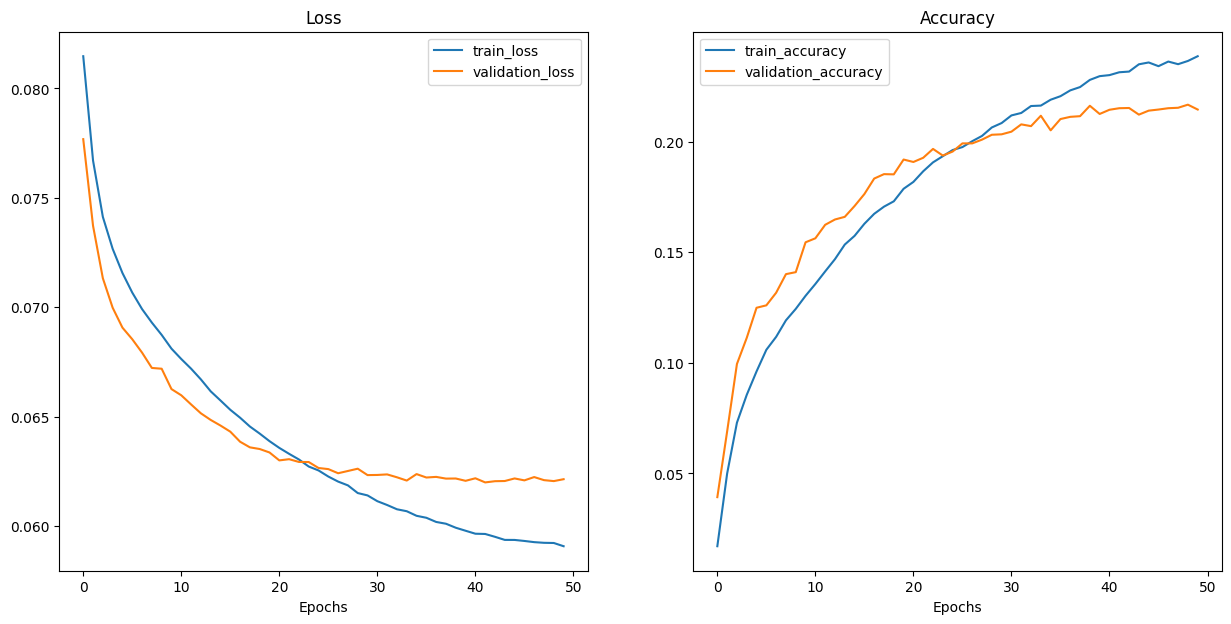

In [63]:
plot_loss_curves(baseline_results)

As we can see our model is learning steadily and the training loss keeps dropping smoothly per epoch. While the accuracy is low, near 20%, this is expected when training a model like the Vision Transformer from scratch is a very difficult task. Vast amounts of data is needed to get any good accuracy on a transformer model. The authors of the original paper pre-trained the model on **JFT-300M** data set and then fine tuned the model on smaller data sets.

## 4 Predicting on unseen data

Let's now use the unseen test data to predict its classes using our model. We will:
1. Create a new model instance
2. Load the saved `baseline_model_weights`
3. Use this model to make some predictions on test images

In [23]:
import random

In [16]:
prod_model = ViT(num_transformer_layers=1)
prod_model.load_state_dict(torch.load("models/baseline_vit.pth"))
prod_model.to(device)

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embed_layer): PatchEmbeddings(
    (patcher): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (tfm_enc_blocks): Sequential(
    (0): TransformerEncoderBlock(
      (msa): MultiHeadSelfAttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
      )
      (mlp): MLPLayer(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=1024, out_features=256, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (fcs): Sequential(
    (0): LayerNor

In [46]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])


def load_test_images():
    test_images_path = "tiny-imagenet-200/test/images"
    images = list(os.listdir(test_images_path))
    test_batch = []
    
    for img in random.sample(images, k=9):
        img_path = os.path.join(test_images_path, img)
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        test_batch.append(img)
    
    return torch.stack(test_batch)


test_batch = load_test_images()
print(f"Number of test images: {len(test_batch)}")
print(f"Shape of test batch: {test_batch.shape}")

Number of test images: 9
Shape of test batch: torch.Size([9, 3, 64, 64])


In [47]:
prod_model.eval()
preds = prod_model(test_batch.to(device))
pred_classes = torch.argmax(preds, dim=1)

In [48]:
print(f"Predicted classes: {pred_classes}")

Predicted classes: tensor([ 84,  12, 171, 183, 133, 189,  70, 176, 186], device='cuda:0')


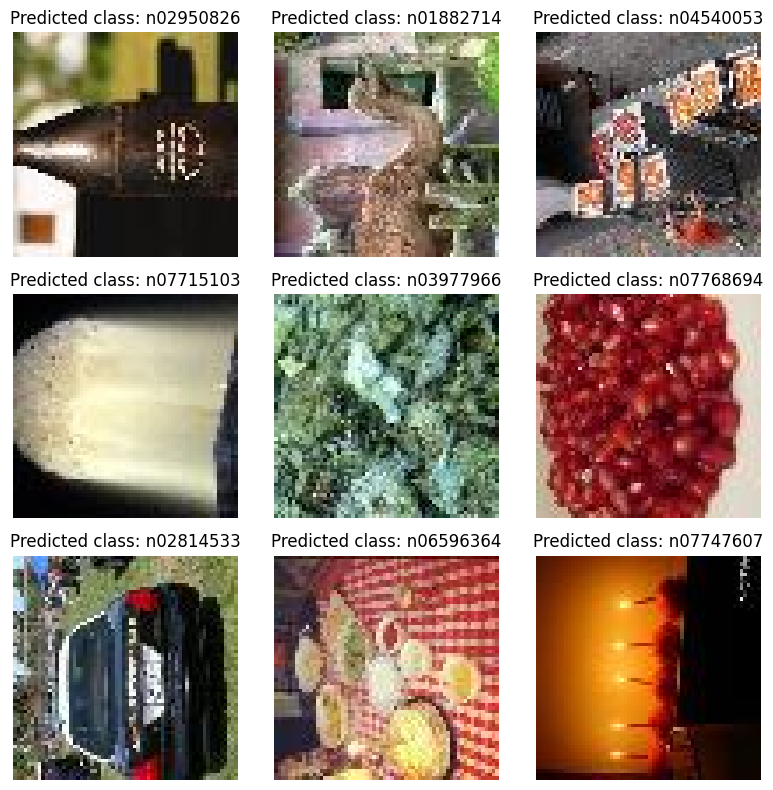

In [49]:
def plot_img_predictions(imgs: list, predictions: list):
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    
    for i, ax in enumerate(ax.flat):
        ax.imshow(imgs[i].permute(2, 1, 0))
        ax.set_title(f"Predicted class: {idx_to_class[predictions[i]]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


plot_img_predictions(test_batch, pred_classes.tolist())

## Conclusion & Next Steps

In this notebook, we successfully implemented a Vision Transformer (ViT) from scratch and trained it on the Tiny ImageNet dataset. We explored key ViT components, including patch embeddings, multi-head self-attention, and transformer encoder blocks, and built a modular training pipeline using PyTorch.

Although training ViTs from scratch on small datasets is challenging, we achieved promising results. Future improvements could include:
✅ Using a pre-trained ViT model for fine-tuning on Tiny ImageNet.
✅ Increasing patch size (e.g., 16×16) to improve computational efficiency.
✅ Exploring data augmentation techniques like MixUp and CutMix.
✅ Visualizing attention maps to understand how the model focuses on different image regions.

This project highlights the potential of transformers in vision tasks and provides a strong foundation for further research in deep learning and computer vision.